# Anomaly Detection with GMM - Part 2
## How to initialise the model?

In the last part we assumed we knew how many components or *clusters* we're looking for. We also chose the model parameter via eye-balling the 2d graphs of the fitted model.

Let's see if we can improve on that, so that no eye-balling is required.

In general we would like to have an automated way of choosing the parameters of the model. With supervised learning it would be easy - just measure the quality of the model (using *accuracy*, *precision/recall*, *F-measure* or *AUC* depending on the problem at hand). How could we do a similar thing with an unsupervised model?

What about measuring the quality by how closely we fit the data? We will have to make sure we don't *overfit*, but that's next. Let's see how this would work.

In [142]:
import numpy as np
import sklearn as sk
from sklearn import mixture
import pandas as pd
%pylab inline

pd.set_option('display.mpl_style', 'default')
plt.rcParams["figure.figsize"] = (18,4)


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


calculating  0 spherical
calculating  0 tied
calculating  0 diag
calculating  0 full
calculating  1 spherical
calculating  1 tied
calculating  1 diag
calculating  1 full
calculating  2 spherical
calculating  2 tied
calculating  2 diag
calculating  2 full


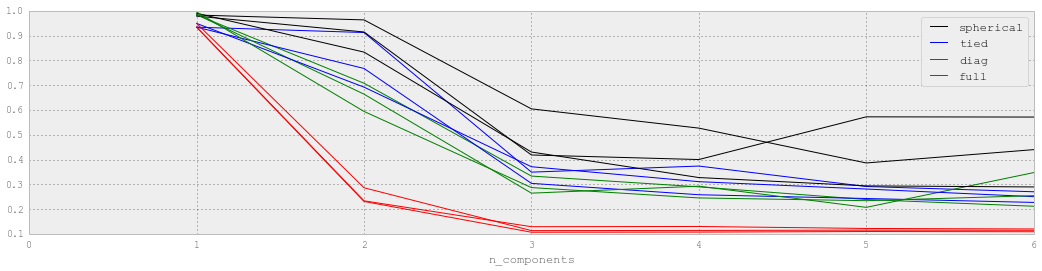

In [143]:
def get_train_data(data_size):
    m=data_size/5
    df1 = pd.DataFrame(random.randn(m,2)-20, columns=['x','y'])
    df2 = pd.DataFrame(random.randn(m*2,2)-10, columns=['x','y'])
    df2.y=-df2.x*3-10 + random.randn(m*2)*2    
    df3 = pd.DataFrame(random.randn(m,2), columns=['x','y'])
    df3.y=df3.x*2-10 + random.randn(m)
    return df1.append(df2).append(df3)
    
def train_anomaly_model(df, n_components=3, cov_type='full'):
    model = mixture.GMM(n_components, covariance_type=cov_type)
    model.fit(df[['x','y']])
    return model

def find_anomaly_limit(df, model, n_falsePositives):
    scores=model.score(df[['x','y']])

    percentile=100*(n_falsePositives / len(scores))

    return np.percentile(np.exp(scores),percentile)

def predict_anomalies(df, model, probability_limit):
    probs=np.exp(model.score(df[['x','y']]))
    return df[probs<probability_limit]

def tight_measure(df, model):
    '''
    How tightly does the `model` fit the data in `df`
    Measured by the number of ratio of:
    - anomalies on uniformly spread grid of points
    - to all of the points
    on the training data set.
    '''
    n_samples = 100
    x = df['x']
    y = df['y']
    probability_limit = find_anomaly_limit(df, model, 100)
    xtest=[[x1,y1] for x1 in np.linspace(x.min(),x.max(),n_samples) for y1 in np.linspace(y.min(), y.max(),n_samples)]
    df_xtest=pd.DataFrame(xtest, columns=['x','y'])
    anomalies = predict_anomalies(df_xtest, model, probability_limit)
    n_normal = len(xtest)-len(anomalies)
#    print n_normal, len(xtest), probability_limit
    return 1.*n_normal/len(xtest)

def iterate(df, cov_type):
    for n_components in np.arange(6)+1:
            model = train_anomaly_model(df, n_components, cov_type)
            yield [n_components, cov_type, tight_measure(df, model)]

ax = pd.DataFrame([1]).plot(legend=False)

for i in np.arange(3):
    df_train = get_train_data(1000)
    
    colors={'spherical':'k', 'tied':'b', 'diag':'g', 'full': 'r'}
    for cov_type in ['spherical', 'tied', 'diag', 'full']:
        print 'calculating ', i, cov_type
        results = pd.DataFrame([x for x in iterate(df_train, cov_type)], columns=['n_components', 'cov_type', cov_type])
        results.plot(x='n_components', y=cov_type, ax=ax, color=colors[cov_type], legend=(i==0))




Now we can use the learning curve to select both the `covariance_type` and the `n_components` which minimise the `tightness` without overfitting.

In the above case we'd select
- covariance_type = full
- n_components = 3

---

# Visualisation

And to see how the tightness measure works in practice we'll iterate over `n_component` values and plot the fitted model.

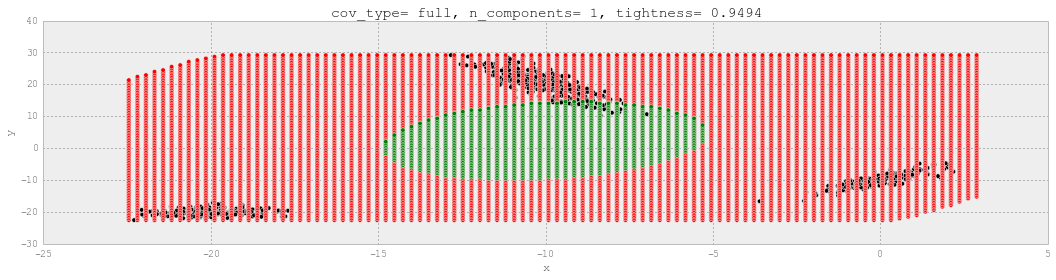

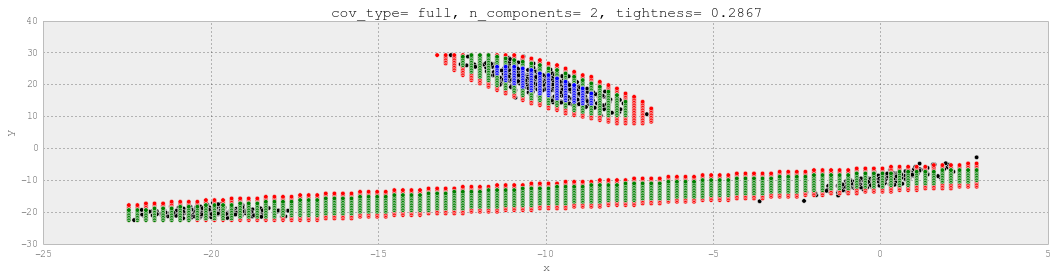

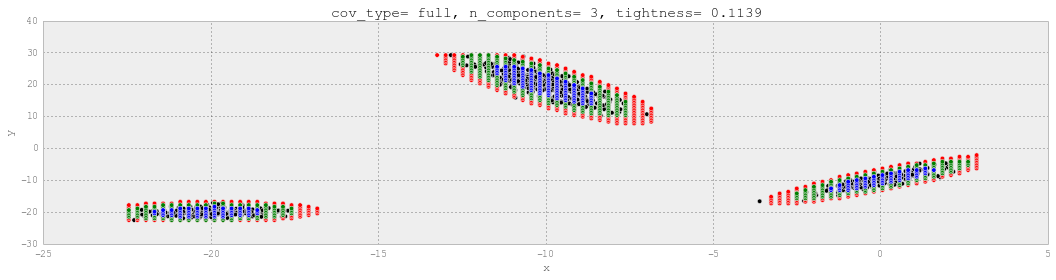

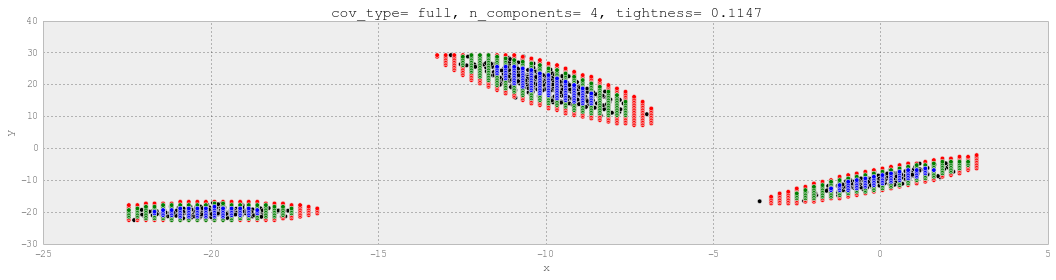

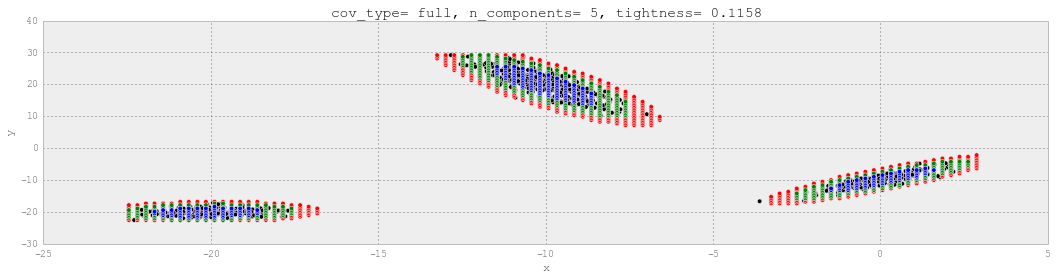

In [144]:
def plot_ranges(df,model,prob=[1e-4,1e-3,1e-2],colors=['r','g','b'], title=''):
    '''Scores the given set of points and plots the defined ranges in various colors'''
    ax = df.plot(kind='scatter', x='x', y='y',color='k')
    x=df['x']
    y=df['y']
    ax.set_title(title)
    n_samples=100
    xtest=[[x1,y1] for x1 in np.linspace(x.min(),x.max(),n_samples) for y1 in np.linspace(y.min(),y.max(),n_samples)]
    dfxtest=pd.DataFrame(xtest, columns=['x','y'])
    ypred=model.score(xtest)
    for i in np.arange(len(prob)):
        shown=dfxtest[exp(ypred)>=prob[i]]
        if len(shown)>0:
            shown.plot(kind='scatter', x='x', y='y', color=colors[i], ax=ax)

for i in np.arange(5)+1:
    model = train_anomaly_model(df_train, i, 'full')
    tightness = tight_measure(df_train, model)
    plot_ranges(df_train, model, title='cov_type= full, n_components= {}, tightness= {}'.format(i, tightness))

# To sum up

We can use a `tightness` measure to evaulate our unsupervised model to give us the `learning curves` which could help us select the optimal parameters for the model.